In [2]:
# Cell 1: Imports and loading
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
import shap
import matplotlib.pyplot as plt
%matplotlib inline

# Load datasets
fraud_data = pd.read_csv(r'C:/Users/Daniel.Temesgen/Desktop/KIAM/week89/Fraud_Data.csv')
creditcard_data = pd.read_csv(r'C:/Users/Daniel.Temesgen/Desktop/KIAM/creditcard.csv')



c:\Users\Daniel.Temesgen\Desktop\KIAM\Improved detection of fraud cases for e-commerce and bank transactions\week89\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
# Cell 2: Preprocessing functions

def preprocess_fraud_data(df):
    df = df.dropna(subset=['user_id', 'purchase_time', 'purchase_value'])
    for col in ['source', 'browser', 'sex']:
        if col in df.columns:
            df[col] = df[col].fillna(df[col].mode()[0])
    df['age'] = df['age'].fillna(df['age'].median())
    df = df.drop_duplicates()
    df['signup_time'] = pd.to_datetime(df['signup_time'])
    df['purchase_time'] = pd.to_datetime(df['purchase_time'])
    df['user_id'] = df['user_id'].astype(int)
    df['purchase_value'] = df['purchase_value'].astype(float)
    df['age'] = df['age'].astype(int)
    user_purchase_counts = df.groupby('user_id').size().reset_index(name='transaction_frequency')
    df = df.merge(user_purchase_counts, on='user_id')
    df['hour_of_day'] = df['purchase_time'].dt.hour
    df['day_of_week'] = df['purchase_time'].dt.dayofweek
    df['time_since_signup'] = (df['purchase_time'] - df['signup_time']).dt.total_seconds() / 3600
    X = df.drop(['class', 'user_id', 'signup_time', 'purchase_time', 'device_id', 'ip_address'], axis=1)
    y = df['class']
    return X, y

def preprocess_creditcard_data(df):
    df = df.dropna(subset=['Amount', 'Class'])
    df = df.drop_duplicates()
    X = df.drop(['Class'], axis=1)
    y = df['Class']
    return X, y


In [5]:
# Cell 3: Preprocessing, encoding, scaling, splitting

X_fraud, y_fraud = preprocess_fraud_data(fraud_data)
X_creditcard, y_creditcard = preprocess_creditcard_data(creditcard_data)

# Encode categorical columns
categorical_cols = ['source', 'browser', 'sex']
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
X_fraud_encoded = pd.DataFrame(encoder.fit_transform(X_fraud[categorical_cols]))
X_fraud_encoded.columns = encoder.get_feature_names_out(categorical_cols)
X_fraud = X_fraud.drop(categorical_cols, axis=1).reset_index(drop=True)
X_fraud = pd.concat([X_fraud, X_fraud_encoded], axis=1)

# Scale features
fraud_scaler = StandardScaler()
X_fraud_scaled = fraud_scaler.fit_transform(X_fraud)

creditcard_scaler = StandardScaler()
X_creditcard_scaled = creditcard_scaler.fit_transform(X_creditcard)

# Train-test split
X_fraud_train, X_fraud_test, y_fraud_train, y_fraud_test = train_test_split(
    X_fraud_scaled, y_fraud, test_size=0.2, stratify=y_fraud, random_state=42)
X_creditcard_train, X_creditcard_test, y_creditcard_train, y_creditcard_test = train_test_split(
    X_creditcard_scaled, y_creditcard, test_size=0.2, stratify=y_creditcard, random_state=42)

# Apply SMOTE
smote = SMOTE(random_state=42)
X_fraud_train_resampled, y_fraud_train_resampled = smote.fit_resample(X_fraud_train, y_fraud_train)
X_creditcard_train_resampled, y_creditcard_train_resampled = smote.fit_resample(X_creditcard_train, y_creditcard_train)


In [7]:
# Cell 4: Train Random Forests and compute SHAP (Optimized)

# You can reduce n_estimators for faster training (optional)
rf_fraud = RandomForestClassifier(random_state=42, n_estimators=100)
rf_fraud.fit(X_fraud_train_resampled, y_fraud_train_resampled)

rf_creditcard = RandomForestClassifier(random_state=42, n_estimators=100)
rf_creditcard.fit(X_creditcard_train_resampled, y_creditcard_train_resampled)

# SHAP explainers using the newer, faster API
explainer_fraud = shap.Explainer(rf_fraud)
explainer_creditcard = shap.Explainer(rf_creditcard)

# Optional: Subsample test sets to speed up SHAP value computation
X_fraud_sample = X_fraud_test[:100]
X_creditcard_sample = X_creditcard_test[:100]

# Compute SHAP values
shap_values_fraud = explainer_fraud(X_fraud_sample)
shap_values_creditcard = explainer_creditcard(X_creditcard_sample)

# For class 1 (fraud), get the SHAP values
shap_values_fraud_class1 = shap_values_fraud.values
shap_values_creditcard_class1 = shap_values_creditcard.values


<Figure size 640x480 with 0 Axes>

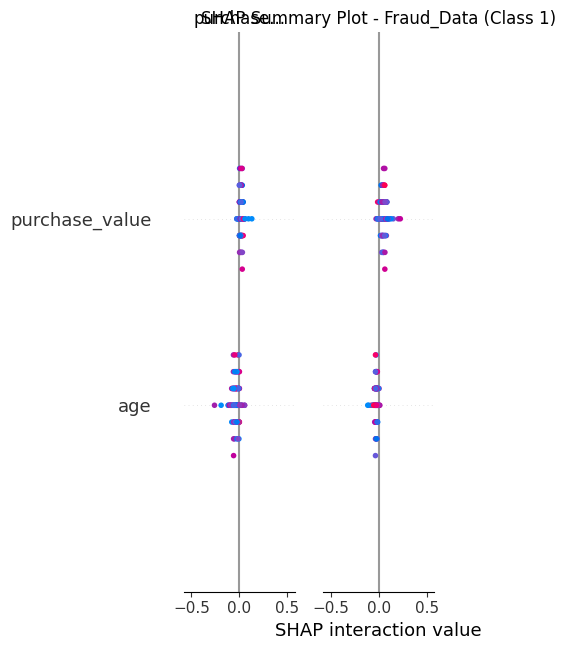

<Figure size 640x480 with 0 Axes>

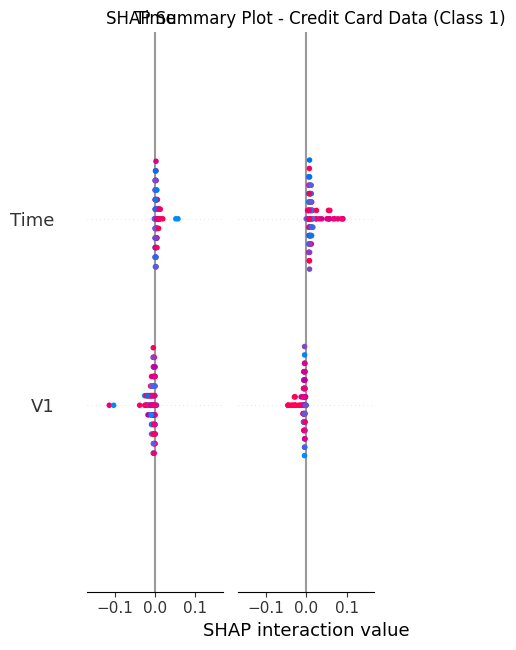

In [7]:
# Cell 5: SHAP Summary Plots (Corrected)

plt.figure()
shap.summary_plot(shap_values_fraud_class1, X_fraud_sample, feature_names=X_fraud.columns, show=False)
plt.title('SHAP Summary Plot - Fraud_Data (Class 1)')
plt.tight_layout()
plt.savefig('shap_summary_fraud.png')
plt.show()

plt.figure()
shap.summary_plot(shap_values_creditcard_class1, X_creditcard_sample, feature_names=X_creditcard.columns, show=False)
plt.title('SHAP Summary Plot - Credit Card Data (Class 1)')
plt.tight_layout()
plt.savefig('shap_summary_creditcard.png')
plt.show()


In [6]:
# Cell 6: SHAP Force Plots

# Fraud Data
fraud_idx = np.where(y_fraud_test == 1)[0][0]
plt.figure()
shap.force_plot(explainer_fraud.expected_value[1], shap_values_fraud_class1[fraud_idx],
                X_fraud_test[fraud_idx], feature_names=X_fraud.columns, matplotlib=True, show=False)
plt.title('SHAP Force Plot - Fraudulent Transaction (Fraud_Data)')
plt.tight_layout()
plt.savefig('shap_force_fraud.png')
plt.show()

# Credit Card Data
creditcard_idx = np.where(y_creditcard_test == 1)[0][0]
plt.figure()
shap.force_plot(explainer_creditcard.expected_value[1], shap_values_creditcard_class1[creditcard_idx],
                X_creditcard_test[creditcard_idx], feature_names=X_creditcard.columns, matplotlib=True, show=False)
plt.title('SHAP Force Plot - Fraudulent Transaction (Credit Card Data)')
plt.tight_layout()
plt.savefig('shap_force_creditcard.png')
plt.show()


NameError: name 'explainer_fraud' is not defined

<Figure size 640x480 with 0 Axes>

In [ ]:
# Cell 7: Interpretation

print('SHAP Interpretation:')
print('\nFraud_Data Summary Plot:')
print('The Summary Plot ranks features by their average impact on fraud predictions. '
      'Features like time_since_signup, transaction_frequency, and hour_of_day are likely top drivers, '
      'with high values (red) increasing fraud likelihood (positive SHAP values) and low values (blue) decreasing it.')

print('\nFraud_Data Force Plot:')
print('For a single fraudulent transaction, the Force Plot shows features like high time_since_signup or unusual hour_of_day '
      'pushing the prediction toward fraud, while features like normal purchase_value may push against it.')

print('\nCredit Card Data Summary Plot:')
print('Features like V4, V14, and Amount are likely key drivers, with high values increasing fraud probability. '
      'The anonymized features (V1-V28) make interpretation domain-specific, but their SHAP values indicate importance.')

print('\nCredit Card Data Force Plot:')
print('For a fraudulent transaction, features like high V14 or Amount contribute positively to the fraud prediction, '
      'while others may reduce the likelihood.')
